<a href="https://colab.research.google.com/github/gyasifred/NLP-Techniques/blob/main/predicting_medical_biobert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict
import numpy as np

In [9]:
def load_and_preprocess_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]:
    """Load and preprocess the training and testing data.

    Args:
        train_path (str): The file path for the training data CSV.
        test_path (str): The file path for the testing data CSV.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]: A tuple containing the training DataFrame,
        the testing DataFrame, and the fitted LabelEncoder.
    """
    try:
        # Load the data
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        # Check if necessary columns exist
        if 'prognosis' not in train_df.columns or 'prognosis' not in test_df.columns:
            raise ValueError("The 'prognosis' column is missing from the datasets.")
        if 'symptoms' not in train_df.columns or 'symptoms' not in test_df.columns:
            raise ValueError("The 'symptoms' column is missing from the datasets.")

        # Initialize and fit the LabelEncoder
        label_encoder = LabelEncoder()
        train_df['prognosis'] = label_encoder.fit_transform(train_df['prognosis'])
        test_df['prognosis'] = label_encoder.transform(test_df['prognosis'])

        return train_df, test_df, label_encoder

    except FileNotFoundError as e:
        print(f"Error: {e}")
        raise
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
        raise
    except Exception as e:
        print(f"An error occurred: {e}")
        raise

In [10]:
# Load and preprocess data
train_df, test_df, label_encoder = load_and_preprocess_data("/content/drive/MyDrive/Training.csv", "/content/drive/MyDrive/Testing.csv")

In [11]:
num_classes = len(label_encoder.classes_)
print(f"Number of classes: {num_classes}")

Number of classes: 41


In [12]:
MODEL_NAME = "dmis-lab/biobert-v1.1"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, attn_implementation='eager',num_labels=num_classes, output_attentions=True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model.to(device)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
class CustomTextDataset(Dataset):
    """Custom Dataset class for text data."""

    def __init__(self, dataframe: pd.DataFrame, tokenizer: BertTokenizer, max_length: int):
        """
        Initializes the dataset with the DataFrame, tokenizer, and max length.

        Args:
            dataframe (pd.DataFrame): DataFrame containing the symptoms and prognosis.
            tokenizer (AutoTokenizer): Tokenizer for the specific transformer model.
            max_length (int): Maximum length of the tokenized input.
        """
        self.tokenizer = tokenizer
        self.texts = dataframe['symptoms'].astype(str).tolist()  # Convert to list for easier indexing
        self.labels = dataframe['prognosis'].values
        self.max_length = max_length

    def __len__(self) -> int:
        """Returns the total number of samples in the dataset."""
        return len(self.texts)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        """Generates one sample of data."""
        text = self.texts[index]
        label = self.labels[index]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"  # Returns PyTorch tensors
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove the extra dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove the extra dimension
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure label is a tensor
        }


In [14]:
def create_data_loaders(train_df: pd.DataFrame, test_df: pd.DataFrame, tokenizer: BertTokenizer, batch_size: int = 16) -> Tuple[DataLoader, DataLoader]:
    """Create DataLoaders for training and testing."""
    train_dataset = CustomTextDataset(train_df, tokenizer, max_length=512)
    test_dataset = CustomTextDataset(test_df, tokenizer, max_length=512)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader

In [15]:
# Create data loaders
train_loader, test_loader = create_data_loaders(train_df, test_df, tokenizer)

In [16]:
def train_model(model: BertForSequenceClassification, train_loader: DataLoader, num_epochs: int = 3):
    """Train the model."""
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)  # Move to the same device as the model
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            try:
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            except RuntimeError as e:
                print(f"Error during forward pass: {e}")
                continue

            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

In [17]:
# Train the model
train_model(model, train_loader)

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1/3, Loss: 2.4730
Epoch 2/3, Loss: 0.5068
Epoch 3/3, Loss: 0.1641


In [25]:
def evaluate_model(model: BertForSequenceClassification, test_loader: DataLoader, label_encoder: LabelEncoder):
    """Evaluate the model."""
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)


In [26]:
# Evaluate the model
evaluate_model(model, test_loader, label_encoder)

Accuracy: 1.0000
Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        25
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        25
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        25
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        25
                            Common Cold       1.00      1.00      1.

In [27]:
def get_predictions_with_probabilities(text: str, model: BertForSequenceClassification, tokenizer: BertTokenizer, label_encoder: LabelEncoder) -> Tuple[str, np.ndarray]:
    """Get predictions with probabilities for a given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)

    predicted_class = probs.argmax(dim=-1).item()
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    return predicted_label, probs.cpu().numpy()[0]

In [28]:
# Example usage of prediction and attention visualization
text_example = "Patient reports severe headache and chest pain."
label, prob = get_predictions_with_probabilities(text_example, model, tokenizer, label_encoder)
print(f"Predicted prognosis: {label}, Probabilities: {prob}")

Predicted prognosis: Heart attack, Probabilities: [0.00549121 0.01239754 0.04765684 0.01170611 0.01556516 0.01731404
 0.0145742  0.02413146 0.00529324 0.00444648 0.01027335 0.00488027
 0.02529874 0.02073122 0.01155075 0.03418066 0.03800474 0.02546851
 0.2755722  0.00327166 0.00386689 0.00616287 0.00672216 0.0533388
 0.00636242 0.00669141 0.00804957 0.01080063 0.00411275 0.05381576
 0.01318039 0.02363965 0.03946341 0.02271271 0.02017885 0.02248961
 0.01056166 0.00710761 0.04681394 0.01395972 0.01216086]


In [29]:
def plot_attention_scores(text: str, model: BertForSequenceClassification, tokenizer: BertTokenizer, layer_num: int = 0, head_num: int = 0):
    """Plot attention scores for a given text."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[layer_num][0, head_num].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    plt.figure(figsize=(10, 8))
    sns.heatmap(attentions, xticklabels=tokens, yticklabels=tokens, cmap='coolwarm')
    plt.title(f'Attention scores (Layer {layer_num}, Head {head_num})')
    plt.show()

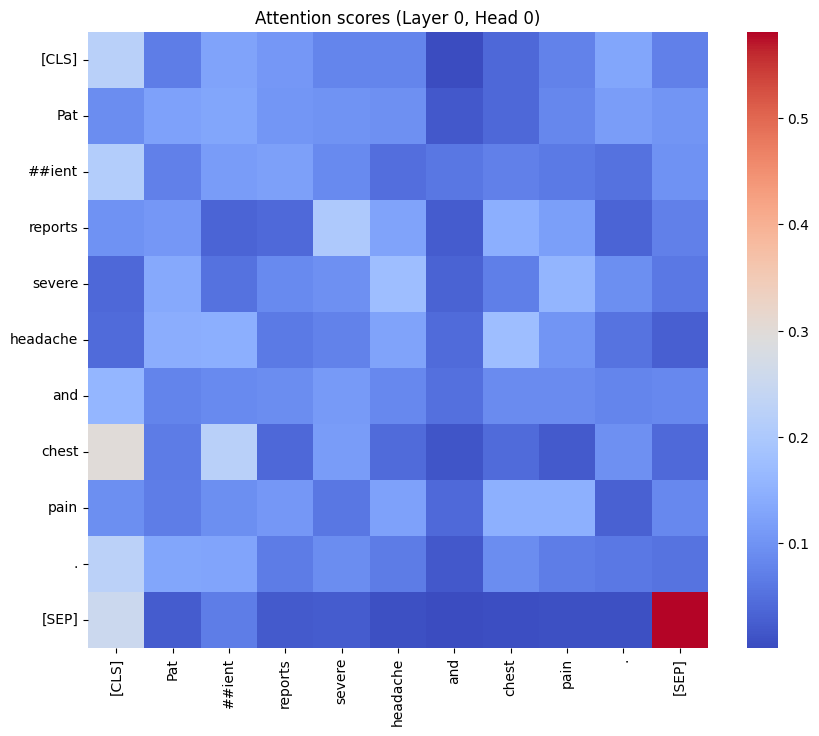

In [30]:
plot_attention_scores(text_example, model, tokenizer)

In [24]:
# Specify the paths for saving the model and tokenizer
model_save_path = "/content/drive/MyDrive/MT/trained_biobert_model"
tokenizer_save_path = '/content/drive/MyDrive/MT/trained_biobert_tokenizer'

# Saving the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print("Model and tokenizer saved locally!")

Model and tokenizer saved locally!
